# PROJECT-3. EDA + Feature Engineering.
## КАКОЙ КЕЙС РЕШАЕМ?

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### Файлы для соревнования
- hotels_train.csv - набор данных для обучения
- hotels_test.csv - набор данных для оценки качества
- submission.csv - файл сабмишна в нужном формате

### Признаки
- hotel_address - адрес отеля
- review_date - дата, когда рецензент разместил соответствующий отзыв.
- average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
- hotel_name - название отеля
- reviewer_nationality - национальность рецензента
- negative_review - отрицательный отзыв, который рецензент дал отелю.
- review_total_negative_word_counts - общее количество слов в отрицательном отзыв
- positive_review - положительный отзыв, который рецензент дал отелю
- review_total_positive_word_counts - общее количество слов в положительном отзыве
- reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
- total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
- total_number_of_reviews - общее количество действительных отзывов об отеле
- tags - теги, которые рецензент дал отелю.
- days_since_review - продолжительность между датой проверки и датой очистки
- additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat - широта отеля
- lng - долгота отеля

In [64]:
# импорт библиотек
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

# фиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [3]:
# Подгрузка данных из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [8]:
sample_submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# 1. Очистка данных

In [10]:
# найдем дубликаты в train датасете
mask = df_train.duplicated(subset=df_train.columns) # маска для фильтрации
data_duplicates = df_train[mask] # фильтруем датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 307


In [11]:
# удалим дубликаты
df_train.drop_duplicates(inplace=True)

In [12]:
# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [13]:
# ищем в столбцах данные, содержащие пропущенные значения
display(data.isnull().sum())

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

### Пропущенные значения имеются в признаках 'lat' и 'lng'. Заполнение пропущенных значений в признаках 'lat' и 'lng' будет выполнено далее на основе новых признаков.

# 2. Проектирование признаков

In [14]:
# ищем в столбцах данные, содержащие числовые значения
digit_columns = [col for col in data.columns if data[col].dtypes != 'object']
digit_columns

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng',
 'sample',
 'reviewer_score']

In [15]:
# ищем в столбцах данные, содержащие строковые значения
object_columns = [col for col in data.columns if data[col].dtypes == 'object']
object_columns

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

## 2.1 Преобразование признака 'hotel_address'

In [16]:
# проверка значений признака
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [17]:
# извлечем из адреса страну отеля и запишем в новый признак
data['hotel_country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('Kingdom') else x.split()[-1])
data['hotel_country'].value_counts()

United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: hotel_country, dtype: int64

In [18]:
# извлечем из адреса город отеля и запишем в новый признак
data['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
data['hotel_city'].value_counts()

London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64

## 2.2 Заполнение пропущенных значений в признаках 'lat', 'lng'

In [19]:
# распределение пропусков в 'lat' по городам
print(data[data['lat'].isnull()].groupby('hotel_city', as_index=False).agg(qty=('hotel_city', 'count')))

  hotel_city   qty
0  Barcelona   207
1      Paris   382
2     Vienna  2679


In [20]:
# распределение пропусков в 'lng' по городам
print(data[data['lng'].isnull()].groupby('hotel_city', as_index=False).agg(qty=('hotel_city', 'count')))

  hotel_city   qty
0  Barcelona   207
1      Paris   382
2     Vienna  2679


In [21]:
# создаем копию датафрейма для исключения конфликта манипуляций с данными
data_coords = data.copy()

# создаем объект SeriesGroupBy
city_data = data_coords.groupby(['hotel_city'], group_keys=False)

# находим медианные координаты с учетом образовавшихся групп
city_data['lat'].median()
city_data['lng'].median()

# используем lambda-функцию к SeriesGroupBy, заполняем пропуски соответствующим медианным значением
data_coords['lat'] = city_data['lat'].apply(lambda x: x.fillna(x.median()))
data_coords['lng'] = city_data['lng'].apply(lambda x: x.fillna(x.median()))

# копируем результат в исходный датафрейм
data = data_coords

# проверяем тип признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [22]:
# проверяем наличие пропусков
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
dtype: int64

### Пропуски в данных теперь отсутствуют.

## 2.3 Создание признака внутреннего туриста

In [23]:
# удаляем лишние пробелы
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

# создаем признак внутреннего туриста
data['domestic_tourist'] = data.apply(lambda x:
    1 if x['hotel_country'] == x['reviewer_nationality'] else 0, axis=1)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

## 2.4 Преобразование признака 'tags'

In [25]:
# преобразование строковых переменных в списки
data['tags'] = data['tags'].apply(lambda x: x[3:-3].split(' \', \' '))

In [26]:
# определение продолжительности пребывания (NaN заполняем значением по умолчанию - 1 сутки)
def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

data['stay_length'] = data['tags'].apply(get_stay)
data['stay_length'].fillna(1, inplace=True)

In [27]:
# определение топ-10 тегов
top_tags = list(data['tags'].explode().value_counts().index)[:10]

# реализуем быстрое кодирование для топ-10 тегов
for tag in top_tags:
    data['tag_'+tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

## 2.5 Преобразование признака 'days_since_review'

In [28]:
# из признака выделим число, меняем тип данных на int
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))
data['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515426    106
515427    171
515428    543
515429     74
515430    363
Name: days_since_review, Length: 515431, dtype: int64

## 2.6 Преобразование признака 'review_date'

In [29]:
# выделим признаки месяца и года из даты отзыва, предварительно приведя признак к формату datetime
data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')
data['review_month'] = data['review_date'].dt.month.astype(int)
data['review_year'] = data['review_date'].dt.year.astype(int)

# удалим исходный признак
data.drop(['review_date'], axis=1, inplace=True)

## 2.7 Преобразование признаков 'negative_review', 'positive_review'

In [30]:
data['negative_review'].value_counts().reset_index().head(25)

,index,negative_review
0,No Negative,127816
1,Nothing,14291
2,Nothing,4234
3,nothing,2223
4,N A,1037
5,None,984
6,,849
7,N a,509
8,Breakfast,407
9,Small room,373


In [31]:
# проанализируем позитивные и негативные отзывы с помощью SentimentIntensityAnalyzer.
sent_analyzer = SentimentIntensityAnalyzer()
neg_score = data['negative_review'].apply(lambda x: -abs(sent_analyzer.polarity_scores(x)['compound']))
pos_score = data['positive_review'].apply(lambda x: abs(sent_analyzer.polarity_scores(x)['compound']))
data['neg_sentiment_score'] = neg_score
data['pos_sentiment_score'] = pos_score
data['sentiment_score'] = pos_score + neg_score

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

# 3. Кодирование признаков

In [33]:
# количество уникальных значений признака 'hotel_name'
data['hotel_name'].nunique()

1492

In [34]:
# произведем кодирование признака 'hotel_name' методом бинарного кодирования (т.к. количество значений ~ 1500)
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

# удалим исходный признак
data.drop(['hotel_name'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

In [35]:
# количество уникальных значений признака 'hotel_city'
data['hotel_city'].nunique()

6

In [36]:
# произведем кодирование признака 'hotel_city' методом однократного кодирования (т.к. количество значений менее 10) 
encoder = ce.OneHotEncoder(cols=['hotel_city'])
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

# удалим исходный признак
data.drop(['hotel_city'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

In [37]:
# количество уникальных значений признака 'reviewer_nationality'
data['reviewer_nationality'].nunique()

227

In [38]:
# произведем кодировку признака 'reviewer_nationality' методом бинарного кодирования (т.к. количество значений более 200)
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

# удалим исходный признак.
data.drop(['reviewer_nationality'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   negative_review                             515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   positive_review                             515431 non-null  object 
 7   review_total_positive_word_counts           515431 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 9   tags                                        515431 non-null  object 
 

# 4. Анализ и отбор признаков

## 4.1 Очистка датасета от исходных (и более не требующихся) признаков

In [39]:
# удалим оставшиеся текстовые признаки
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 53 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   days_since_review                           515431 non-null  int64  
 7   lat                                         515431 non-null  float64
 8   lng                                         515431 non-null  float64
 9   sample                                      515431 non-null  int64  
 

## 4.2 Анализ мультиколлинеарности

<AxesSubplot:>

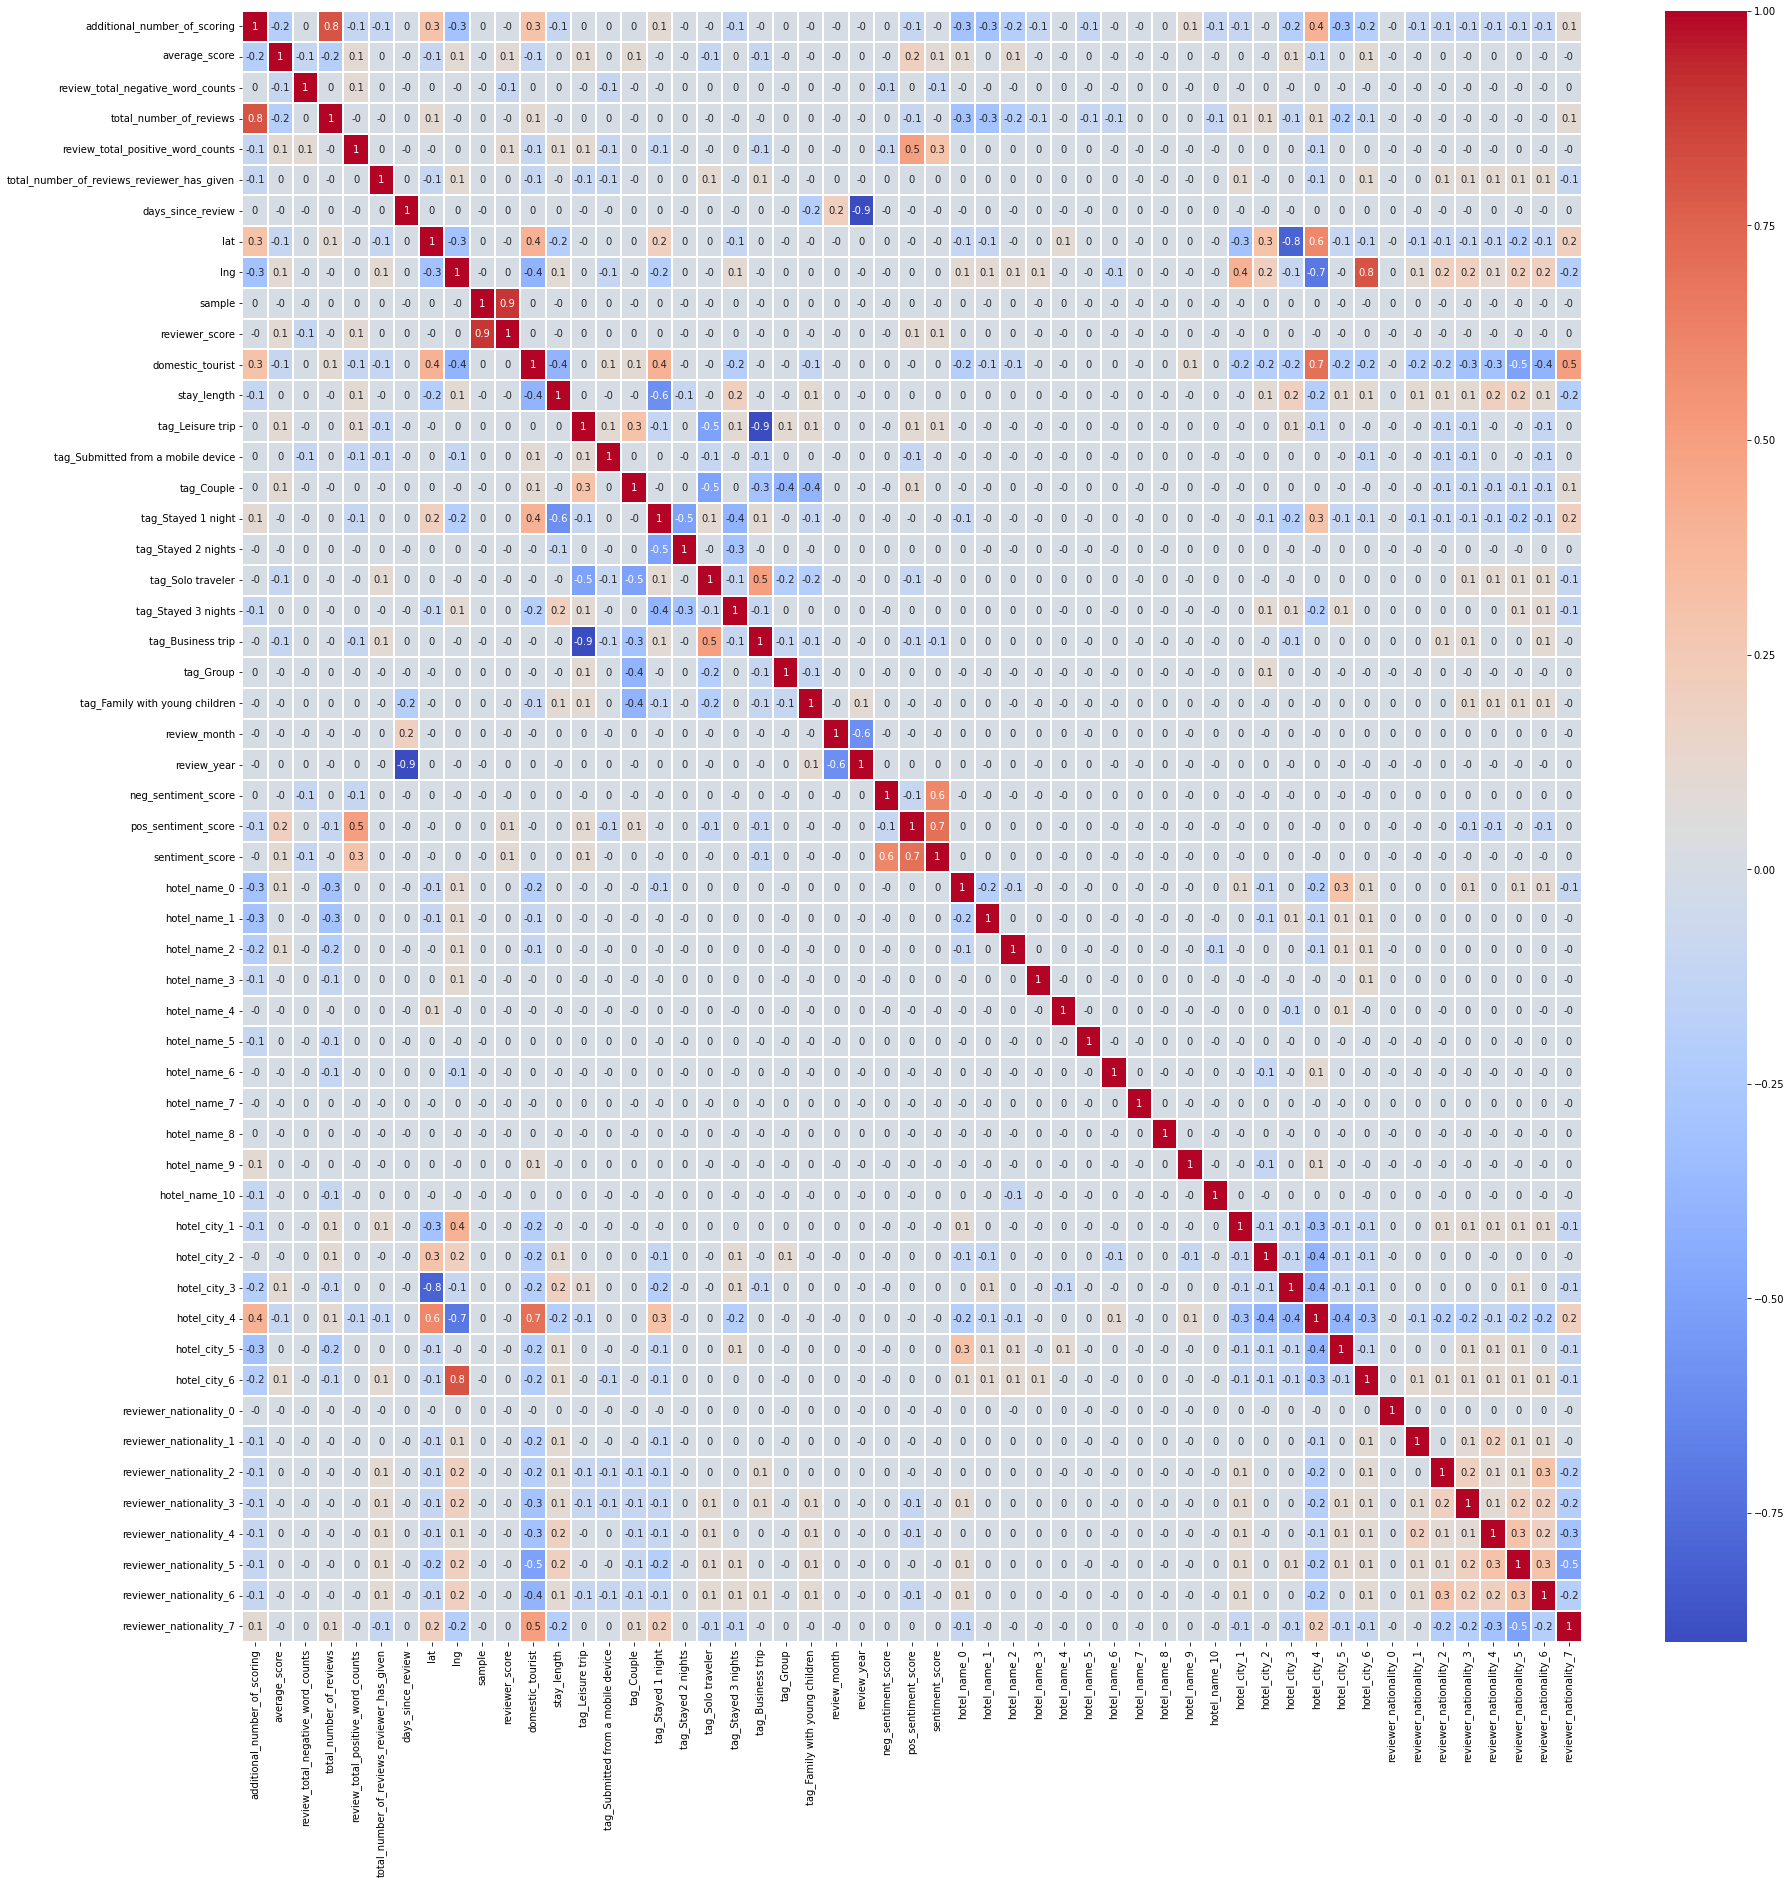

In [40]:
# построим тепловую карту корреляции
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(round(data.corr(), 1), annot=True, linewidths=.1, ax=ax, cmap='coolwarm')

#### Произведем отбор признаков с очень сильной корреляцией (где коэффициент корреляции +/-0.7 и выше):
- additional_number_of_scoring -- total_number_of_reviews
- reviewer_score -- sample
- days_since_review -- review_year
- tag_Leisure trip -- tag_Business trip
- pos_sentiment_score -- sentiment_score
- lat -- hotel_city_3
- lng -- hotel_city_4
- domestic_tourist -- hotel_city_4
- lng -- hotel_city_6

In [41]:
data['lng'].value_counts()

-0.023221     4789
-0.120867     4256
-0.116591     4169
-0.191707     3578
-0.078058     3212
              ... 
 2.320106       12
-0.076461       12
 9.155036       10
 2.329364       10
 16.284504       8
Name: lng, Length: 1472, dtype: int64

In [42]:
# удалим признаки с мультиколлинеарностью
data.drop(
    ['additional_number_of_scoring',
     'days_since_review',
     'tag_Business trip',
     'sentiment_score',
     'hotel_city_3',
     'hotel_city_4',
     'hotel_city_6'],
    axis=1, inplace=True)


<AxesSubplot:>

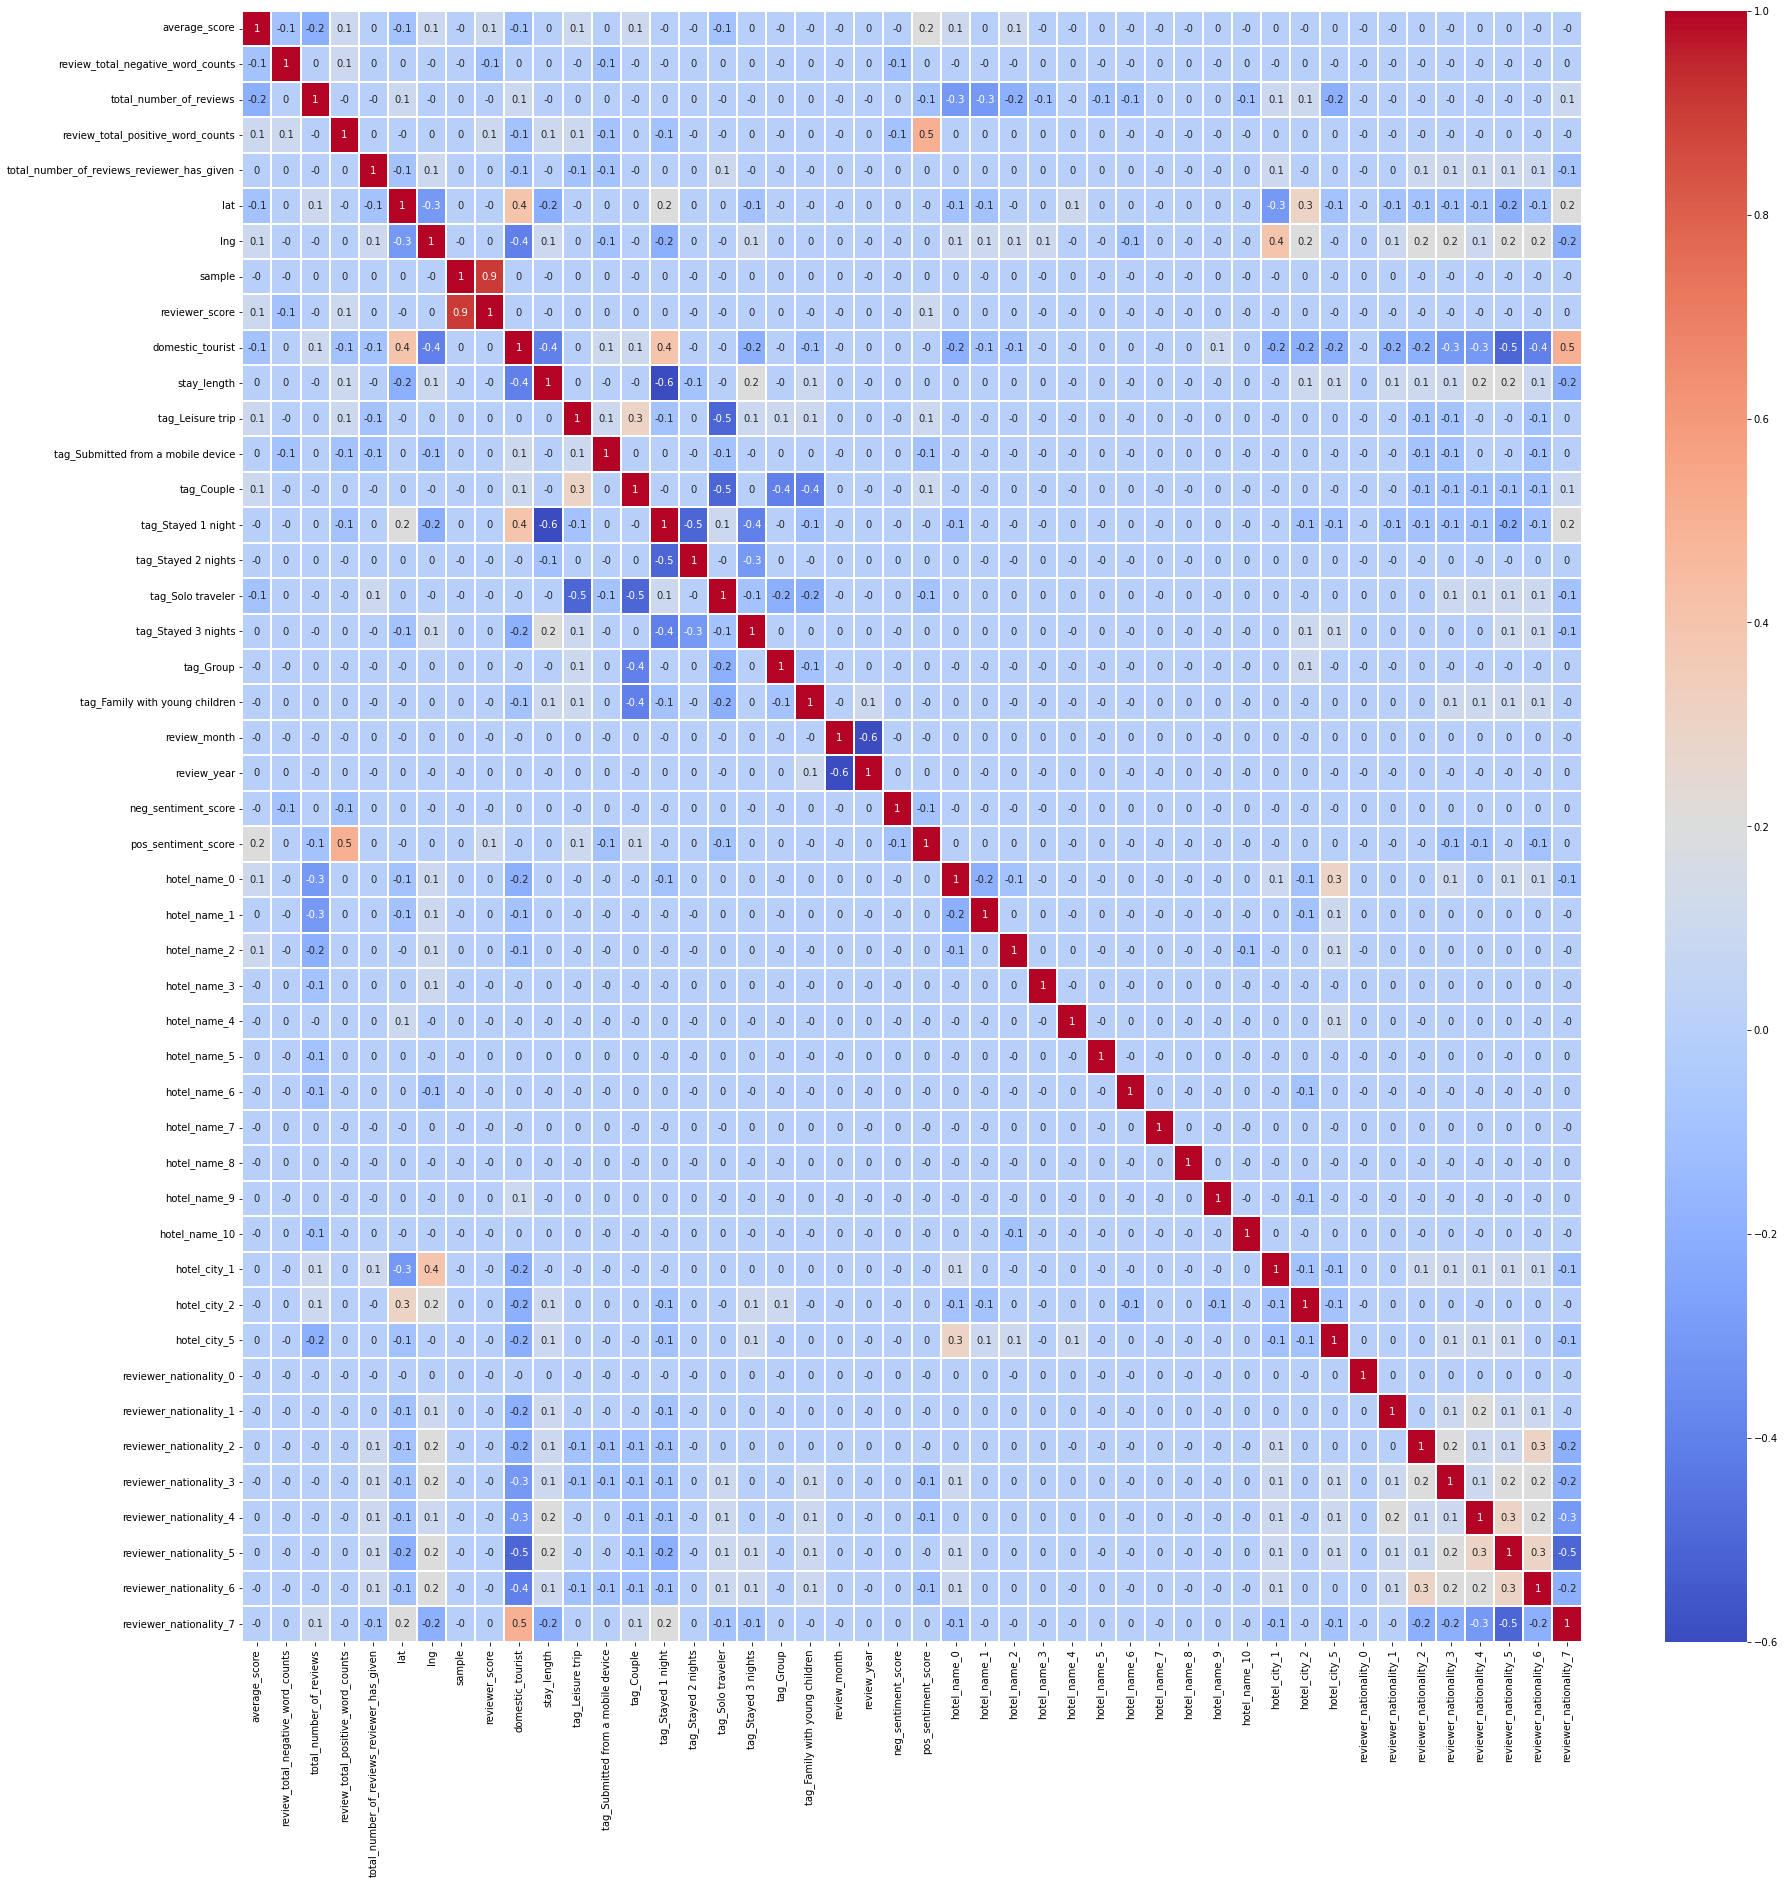

In [43]:
# построим тепловую карту корреляции
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(round(data.corr(), 1), annot=True, linewidths=.1, ax=ax, cmap='coolwarm')

#### Признаки с очень сильной корреляцией отсутствуют, за исключением пары reviewer_score -- sample. Признак 'sample' будет удален при разделение датасета на train и test.

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   total_number_of_reviews                     515431 non-null  int64  
 3   review_total_positive_word_counts           515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 5   lat                                         515431 non-null  float64
 6   lng                                         515431 non-null  float64
 7   sample                                      515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   domestic_tourist                            515431 non-null  int64  
 

## 4.3 Оценка значимости признаков

In [45]:
# разделим признаки на непрерывные и категориальные

# непрерывные признаки
num_cols = ['average_score', 'total_number_of_reviews',
            'review_total_negative_word_counts', 'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given',
            'stay_length', 'neg_sentiment_score', 'pos_sentiment_score']

# категориальные и бинарные признаки (использована только часть признаков для большей наглядности)
cat_cols = ['review_month', 'review_year', 'domestic_tourist',
            'hotel_city_1', 'hotel_city_2', 'hotel_city_5']

<AxesSubplot:>

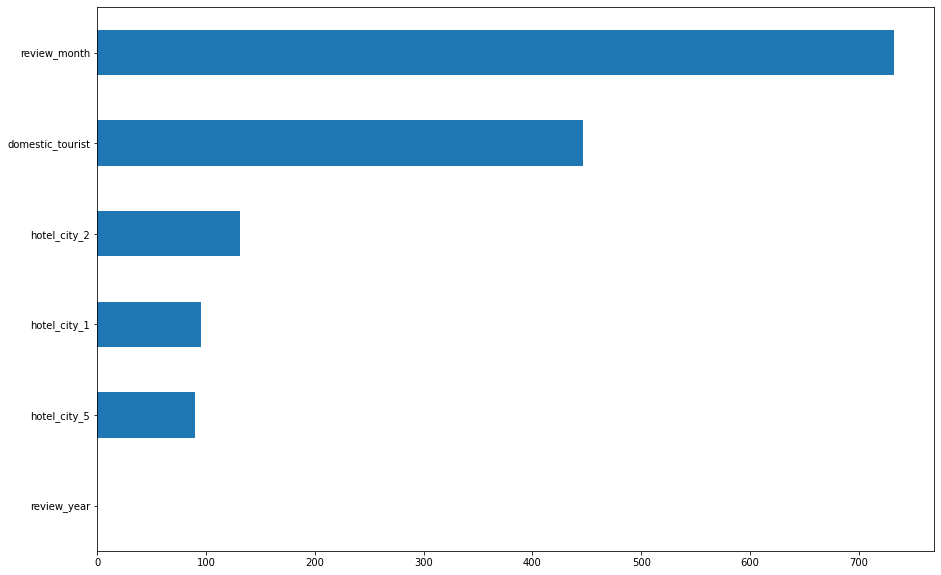

In [46]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

# оценим влияние категориальных признаков при помощи теста хи-квадрат
y = y.astype('int')
plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

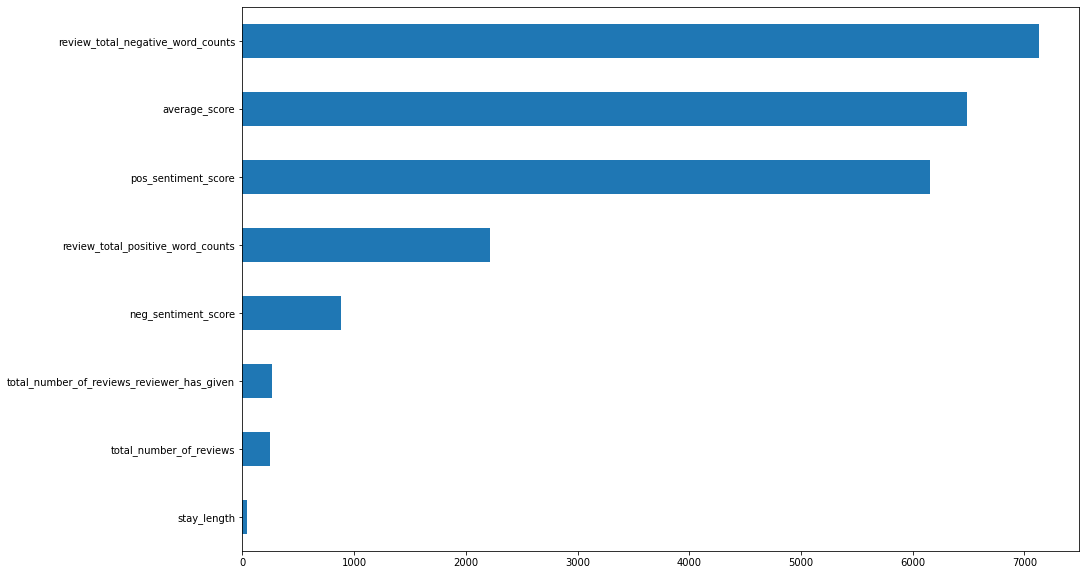

In [47]:
# оценим влияние числовых признаков при помощи теста ANOVA

plt.rcParams['figure.figsize'] = (15,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [48]:
# удалим признаки с низким рейтингом

data.drop(['review_year', 'stay_length'],axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   total_number_of_reviews                     515431 non-null  int64  
 3   review_total_positive_word_counts           515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 5   lat                                         515431 non-null  float64
 6   lng                                         515431 non-null  float64
 7   sample                                      515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   domestic_tourist                            515431 non-null  int64  
 

# 5. Обучение модели и получение предсказания

In [49]:
# pазбиваем датафрейм на части, необходимые для обучения и тестирования модели
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей) 
y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [50]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [51]:
# проверяем размерность получившихся датасетов
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 43), (386496, 43), (386496, 42), (309196, 42), (77300, 42))

In [52]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [53]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [54]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
# Функция для вычисления MAPE
def mean_absolute_percentage_error(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 12.96399730932752


<AxesSubplot:>

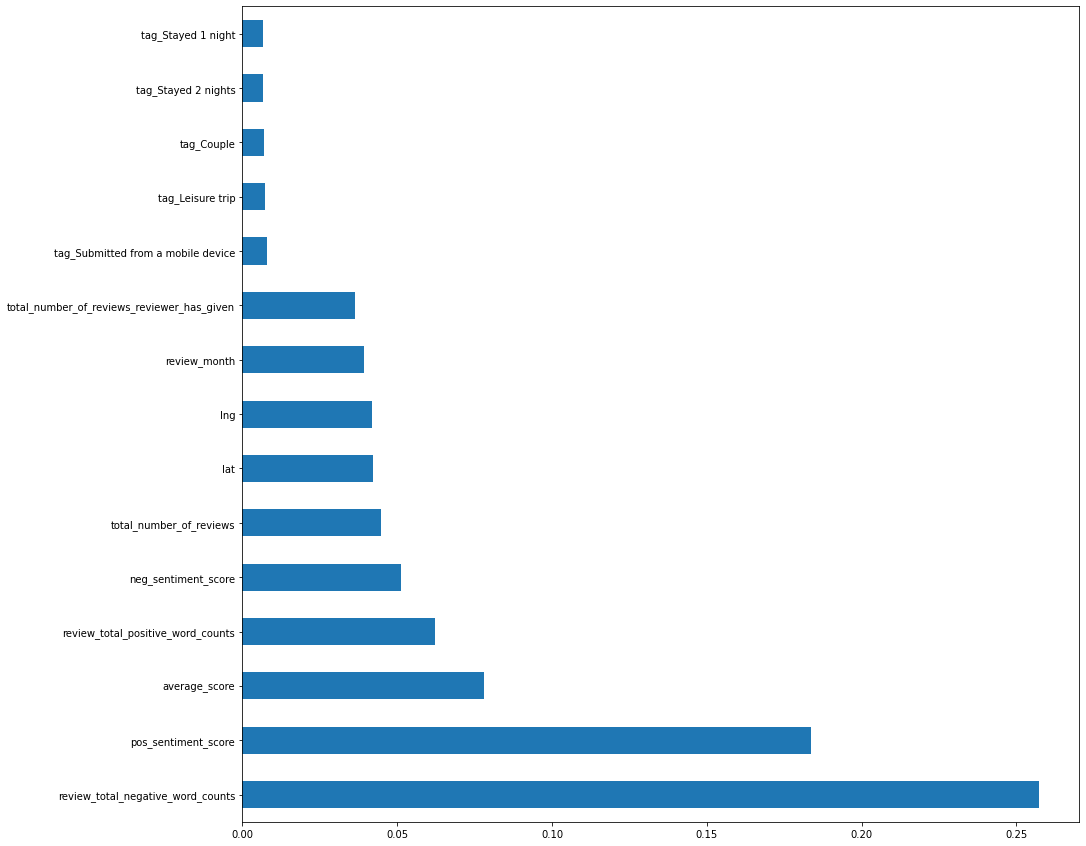

In [63]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15,15)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [56]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,domestic_tourist,tag_Leisure trip,...,hotel_city_2,hotel_city_5,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
1023,7.6,0,301,9,2,51.521526,-0.153304,0.0,1,1,...,0,0,0,0,0,0,0,0,0,1
71667,8.9,0,2836,9,3,51.507271,-0.021121,0.0,0,1,...,0,0,0,0,0,0,1,1,0,0
49192,8.8,52,1324,9,1,48.194577,16.346356,0.0,0,1,...,0,0,0,0,0,0,0,0,0,1
89675,8.5,8,753,0,8,48.200561,16.364706,0.0,0,1,...,0,0,0,0,1,0,0,1,1,0
89477,8.6,0,2865,71,24,52.376418,4.900220,0.0,0,1,...,1,0,0,0,0,1,0,1,0,0
27641,9.0,15,707,8,2,48.886563,2.332965,0.0,0,1,...,0,1,0,0,0,0,0,0,0,1
71812,9.4,56,59,57,3,48.870963,2.315414,0.0,0,1,...,0,1,0,0,0,0,0,0,0,1
69387,9.1,6,902,7,14,51.494308,-0.175558,0.0,1,1,...,0,0,0,0,0,0,0,0,0,1
15770,8.1,14,1632,54,6,48.213425,16.383131,0.0,0,1,...,0,0,0,0,0,1,0,1,0,1
116414,8.4,9,4660,10,2,51.493847,-0.191758,0.0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [57]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [58]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [59]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [60]:
predict_submission

array([8.68 , 7.247, 8.555, ..., 7.536, 9.596, 7.484])

In [61]:
list(sample_submission)

['reviewer_score', 'id']

In [62]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.680,488440
1,7.247,274649
2,8.555,374688
3,9.719,404352
4,9.603,451596
5,8.386,302161
6,7.839,317079
7,7.169,13963
8,8.321,159785
9,7.548,195089
